In [1]:
import pickle
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!pip3 install statsmodels

In [3]:
!pip3 install pmdarima

In [4]:
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import auto_arima

In [5]:
df_risk_info = pd.read_csv('../df_risk_info_2021-12-11.csv')

In [6]:
with open('../stock_info_2021-12-11.pickle', 'rb') as handle:
    stock_info = pickle.load(handle)

with open('../stock_history_2021-12-11.pickle', 'rb') as handle:
    stock_history = pickle.load(handle)

In [7]:
ticker = "V"
stock_cols = ["Close", "ticker"]

In [8]:
df = stock_history[ticker]
df.index = df['Date']
df = df[stock_cols]
print(df.shape)

(756, 2)


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 756 entries, 2018-12-12 to 2021-12-10
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   756 non-null    float64
 1   ticker  756 non-null    object 
dtypes: float64(1), object(1)
memory usage: 17.7+ KB


In [10]:
df.head()

,Close,ticker
Date,,
2018-12-12,137.800003,V
2018-12-13,137.539993,V
2018-12-14,135.089996,V
2018-12-17,131.399994,V
2018-12-18,132.660004,V


In [11]:
df.tail()

,Close,ticker
Date,,
2021-12-06,202.679993,V
2021-12-07,207.369995,V
2021-12-08,208.990005,V
2021-12-09,211.389999,V
2021-12-10,213.399994,V


In [12]:
def test_stationarity(ts, window):
    
    # 주어진 window에 따라 Rolling statistics 계산
    rolmean = ts.rolling(window).mean()
    rolstd = ts.rolling(window).std()
    
    # Rolling statistics 그래프
    plt.figure(figsize=(8,4))
    plt.plot(ts, color='blue', label='Original')
    plt.plot(rolmean, color='red', label=f'Rolling Mean: {window}')
    plt.plot(rolstd, color='black', label=f'Rolling Std: {window}')
    plt.title(f'Rolling Mean and Standard Deviation: {window}')
    plt.legend(loc='best')
    plt.show()
    
    print("Dickey fuller 검정법 결과")
    adft = adfuller(ts, autolag='AIC')
    output = pd.Series(adft[0:4], index=['Test Statistics', 'p-value',
                                         'No. of lags used', 'Number of observations used'])
    for key, values in adft[4].items():
        output['critical value (%s)'%key] = values
    print(output)
    print('\n----------------------------------------')
    print("귀무가설(H0): 주어진 시계열이 정상성을 가지지 않는다.")
    print("대립가설(H1): 주어진 시계열은 정상성을 갖는다.\n")
    
    # 가설 검정 결론 (유의수준 vs. p-value)
    p_val = round(output["p-value"],3)
    if output["p-value"] > 0.05:
        print(f"[결론] 유의수준(0.05) < p-value({p_val})이므로 귀무가설 채택(fail to reject)한다.")
        print(f"..... 주어진 시계열은 정상성을 가지지 않으므로 차분 작업 필요하다.")
    else:
        print(f"[결론] 유의수준(0.05) > p-value({p_val})이므로 귀무가설 기각(reject)한다.")
        print(f"..... 주어진 시계열은 정상성을 갖는다.")

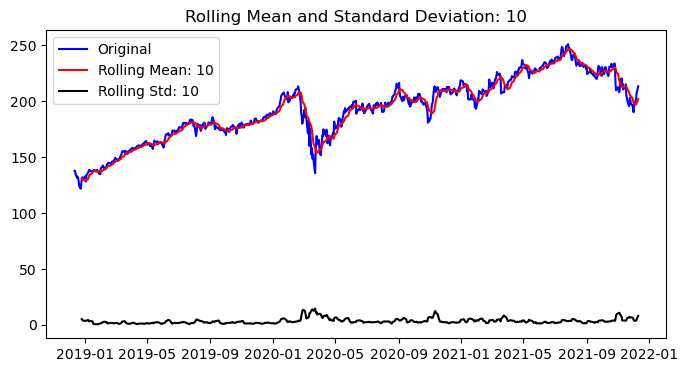

Dickey fuller 검정법 결과
Test Statistics                 -2.199808
p-value                          0.206315
No. of lags used                16.000000
Number of observations used    739.000000
critical value (1%)             -3.439230
critical value (5%)             -2.865459
critical value (10%)            -2.568857
dtype: float64

----------------------------------------
귀무가설(H0): 주어진 시계열이 정상성을 가지지 않는다.
대립가설(H1): 주어진 시계열은 정상성을 갖는다.

[결론] 유의수준(0.05) < p-value(0.206)이므로 귀무가설 채택(fail to reject)한다.
..... 주어진 시계열은 정상성을 가지지 않으므로 차분 작업 필요하다.


In [13]:
test_stationarity(df["Close"], 10)

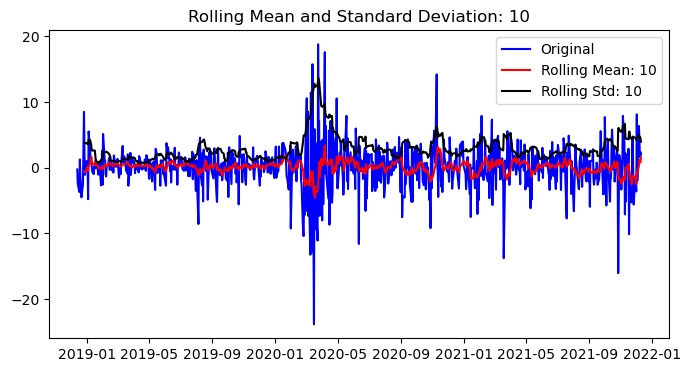

Dickey fuller 검정법 결과
Test Statistics               -6.504808e+00
p-value                        1.138156e-08
No. of lags used               1.500000e+01
Number of observations used    7.390000e+02
critical value (1%)           -3.439230e+00
critical value (5%)           -2.865459e+00
critical value (10%)          -2.568857e+00
dtype: float64

----------------------------------------
귀무가설(H0): 주어진 시계열이 정상성을 가지지 않는다.
대립가설(H1): 주어진 시계열은 정상성을 갖는다.

[결론] 유의수준(0.05) > p-value(0.0)이므로 귀무가설 기각(reject)한다.
..... 주어진 시계열은 정상성을 갖는다.


In [14]:
# d=1 로 1차분 했을 때 정상성 확인

df["Close_diff"] = df["Close"].diff()
df.dropna(inplace=True)

test_stationarity(df["Close_diff"], 10)

In [15]:
model_autoARIMA = auto_arima(df['Close'])

In [16]:
model_autoARIMA = auto_arima(df['Close'],
                             start_p=0, start_q=0, # p, q 시작값
                             max_p=3, max_q=3,     # p and q 최댓값
                             test='adf',           # adf를 통해 d 계산
                             d=None,               # 모델을 통해 d 지정
                             m=1,                  # 연(year)간 데이터
                             seasonal=False,       # 계절성 없음
                             trace=True,           # 값 보여줌
                             with_intercept='auto',# 상수 자동으로 포함/비포함 결정
                             stepwise=True         # p, q 조합으로 진행
                            )
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4033.165, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4017.329, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4019.236, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4031.788, Time=0.01 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=4017.191, Time=0.05 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=4019.127, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4019.179, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4017.740, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4016.062, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4012.726, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3980.722, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4018.725, Time=0.06 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3982.690, Time=0.33 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4007.307, Time=0.09 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept

In [17]:
# 모델 진단

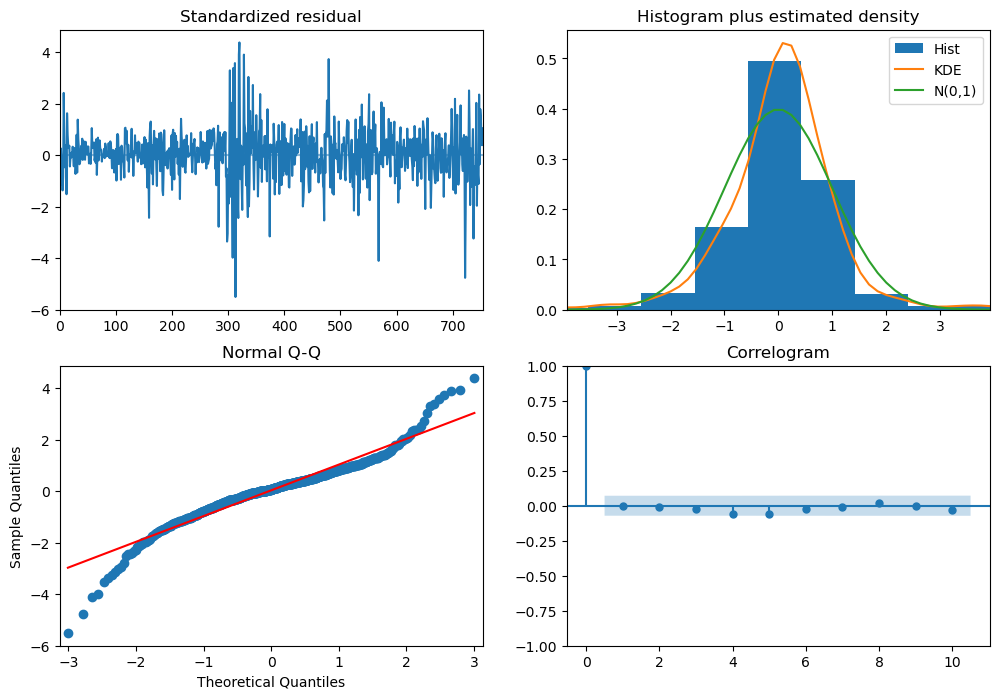

In [18]:
model_autoARIMA.plot_diagnostics(figsize=(12,8))
plt.show()

In [19]:
future_forecast = model_autoARIMA.predict(n_periods=10)
future_forecast

/opt/homebrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


755    214.555419
756    213.461992
757    214.337055
758    213.787812
759    213.963570
760    214.148336
761    213.668346
762    214.341129
763    213.595966
764    214.294934
dtype: float64

In [20]:
# train data: 90%, test data: 10%

training_perc = 0.90
train = df[:int(len(df)*training_perc)]
test = df[int(len(df)*training_perc):]

In [21]:
print(train.shape)
train.tail()

(679, 3)


,Close,ticker,Close_diff
Date,,,
2021-08-18,231.630005,V,-2.899994
2021-08-19,231.570007,V,-0.059998
2021-08-20,231.360001,V,-0.210007
2021-08-23,234.139999,V,2.779999
2021-08-24,234.240005,V,0.100006


In [22]:
print(test.shape)
test.head()

(76, 3)


,Close,ticker,Close_diff
Date,,,
2021-08-25,232.589996,V,-1.650009
2021-08-26,230.520004,V,-2.069992
2021-08-27,232.690002,V,2.169998
2021-08-30,231.229996,V,-1.460007
2021-08-31,229.100006,V,-2.129990


In [23]:
model_autoARIMA = auto_arima(train['Close'],
                             start_p=0, start_q=0, # p, q 시작값
                             max_p=3, max_q=3,     # p and q 최댓값
                             test='adf',           # adf를 통해 d 계산
                             d=None,               # 모델을 통해 d 지정
                             m=1,                  # 연(year)간 데이터
                             seasonal=False,       # 계절성 없음
                             trace=True,           # 값 보여줌
                             with_intercept='auto',# 상수 자동으로 포함/비포함 결정
                             stepwise=True         # p, q 조합으로 진행
                            )
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=9068.934, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3598.702, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=3616.291, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=3594.400, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=7335.992, Time=0.11 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=3593.683, Time=0.13 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=3555.491, Time=0.10 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=3586.496, Time=0.09 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=3557.253, Time=0.12 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=3583.276, Time=0.16 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=3553.248, Time=0.28 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=3593.536, Time=0.13 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=3

In [24]:
test

,Close,ticker,Close_diff
Date,,,
2021-08-25,232.589996,V,-1.650009
2021-08-26,230.520004,V,-2.069992
2021-08-27,232.690002,V,2.169998
2021-08-30,231.229996,V,-1.460007
2021-08-31,229.100006,V,-2.129990
...,...,...,...
2021-12-06,202.679993,V,6.359985
2021-12-07,207.369995,V,4.690002
2021-12-08,208.990005,V,1.620010


In [30]:
future_forecast = model_autoARIMA.predict(n_periods=len(test))
future_forecast = pd.DataFrame(future_forecast, index=test.index,
                               columns=['prediction'])
                                          
pd.concat([test, future_forecast], axis=1)
future_forecast

/opt/homebrew/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,prediction
Date,
2021-08-25,NaN
2021-08-26,NaN
2021-08-27,NaN
2021-08-30,NaN
2021-08-31,NaN
...,...
2021-12-06,NaN
2021-12-07,NaN
2021-12-08,NaN


In [26]:
test_forecast = test.join(future_forecast)
test_forecast

,Close,ticker,Close_diff,prediction
Date,,,,
2021-08-25,232.589996,V,-1.650009,NaN
2021-08-26,230.520004,V,-2.069992,NaN
2021-08-27,232.690002,V,2.169998,NaN
2021-08-30,231.229996,V,-1.460007,NaN
2021-08-31,229.100006,V,-2.129990,NaN
...,...,...,...,...
2021-12-06,202.679993,V,6.359985,NaN
2021-12-07,207.369995,V,4.690002,NaN
2021-12-08,208.990005,V,1.620010,NaN


In [27]:
def rmse(y, y_pred):
    return np.sqrt(np.mean(np.square(y-y_pred)))

In [28]:
rmse(test_forecast["Close"], test_forecast["prediction"])

nan

In [29]:
import math
from sklearn.metrics import mean_squared_error
rmse = math.sqrt(mean_squared_error(test_forecast["Close"],
                                    test_forecast["prediction"]))
rmse

ValueError: Input contains NaN.